In [2]:
#### Model test code ####
# This file contains the code handling the results of the model testing.
# It calculates the model using functions from processing_helpers.py and 
# plots the model togheter with measured data.
# Some error calculations as well as a case study is also performed. 

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import signal

from processing_helpers import get_energy
from processing_helpers import get_con_energy
from processing_helpers import get_residuals

In [4]:
### Constants ###

V = 3.7            #V
hour = 3600        #s
delta_t = 0.00025  #s
joule_to_uWh = 0.000277777778*1000*1000 #uWh

In [5]:
### Read OTII measurment data ###

coap_256_nb    = pd.read_csv("../measurements/otii/model_test_coap_256_nb.csv"   , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_256_ltem  = pd.read_csv("../measurements/otii/model_test_coap_256_ltem.csv" , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_1280_nb   = pd.read_csv("../measurements/otii/model_test_coap_1280_nb.csv"  , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_1280_ltem = pd.read_csv("../measurements/otii/model_test_coap_1280_ltem.csv", usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh

mqtt_256_nb    = pd.read_csv("../measurements/otii/model_test_mqtt_256_nb.csv"   , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_256_ltem  = pd.read_csv("../measurements/otii/model_test_mqtt_256_ltem.csv" , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_4096_nb   = pd.read_csv("../measurements/otii/model_test_mqtt_4096_nb.csv"  , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_4096_ltem = pd.read_csv("../measurements/otii/model_test_mqtt_4096_ltem.csv", usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh

In [6]:
### Read the regression coefficients calculated in processing_sweep.ipynb ###

regression_results = pd.read_csv("reg_res.csv")

timing_coap_nb = regression_results["timing_coap_nb"].to_numpy()
energy_coap_nb = regression_results["energy_coap_nb"].to_numpy()
timing_coap_ltem = regression_results["timing_coap_ltem"].to_numpy()
energy_coap_ltem = regression_results["energy_coap_ltem"].to_numpy()
timing_mqtt_nb = regression_results["timing_mqtt_nb"].to_numpy()
energy_mqtt_nb = regression_results["energy_mqtt_nb"].to_numpy()
timing_mqtt_ltem = regression_results["timing_mqtt_ltem"].to_numpy()
energy_mqtt_ltem = regression_results["energy_mqtt_ltem"].to_numpy()


In [7]:
#device parameters
p_idle       = 157.7*V #uW
coap_p_sleep = 108*V   #uW
mqtt_p_sleep = 117*V   #uW


In [8]:
## Function for getting the start segment of the data ## 
def get_data_start(data):

    diff_array = np.diff(data, axis=0)

    i = 160000
    while(diff_array[i] < 0.01):
        i -= 1
    return [i*delta_t, data[i][0]]


In [9]:
### Estimating the cDRX energy for NB-IoT and LTE-M ###

#NB-IoT
E_cdrx_nb = get_con_energy(
    t_inactive   = 20.48, #s  
    t_cycle      = 2.048, #s  
    t_onDuration = 0.200, #s  
    E_monitor    = 2.580, #uWh
    E_release    = 2.171, #uWh
    p_idle  = p_idle)

#LTE-M
E_cdrx_ltem = get_con_energy(
    t_inactive   = 10.24, #s  
    t_cycle      = 0.320, #s  
    t_onDuration = 0.100, #s  
    E_monitor    = 3.227, #uWh
    E_release    = 0.448, #uWh
    p_idle  = p_idle
)

In [10]:
### The different tests are defined and put in arrays for easy iteration ###

class Test:
    def __init__(self, data, T_msg, n_bytes, t, E, E_start, cdrx):
        self.data = data
        self.duration = np.linspace(0,len(data)*0.00025,len(data))    
        self.T_msg = T_msg
        self.n_bytes = n_bytes
        self.t = t
        self.E = E
        self.E_start = E_start
        self.cdrx = cdrx

coap_test_array = []
coap_test_array.append(Test(coap_256_nb,    300,256, timing_coap_nb,   energy_coap_nb,   get_data_start(coap_256_nb  ), E_cdrx_nb))
coap_test_array.append(Test(coap_256_ltem,  300,256, timing_coap_ltem, energy_coap_ltem, get_data_start(coap_256_ltem ), E_cdrx_ltem))
coap_test_array.append(Test(coap_1280_nb,   300,1280,timing_coap_nb,   energy_coap_nb,   get_data_start(coap_1280_nb ), E_cdrx_nb))
coap_test_array.append(Test(coap_1280_ltem, 300,1280,timing_coap_ltem, energy_coap_ltem, get_data_start(coap_1280_ltem), E_cdrx_ltem))


mqtt_test_array = []
mqtt_test_array.append(Test(mqtt_256_nb,    300,256,  timing_mqtt_nb,   energy_mqtt_nb,   get_data_start(mqtt_256_nb), E_cdrx_nb))
mqtt_test_array.append(Test(mqtt_256_ltem,  300,256,  timing_mqtt_ltem, energy_mqtt_ltem, get_data_start(mqtt_256_ltem), E_cdrx_ltem))
mqtt_test_array.append(Test(mqtt_4096_nb,   300,4096, timing_mqtt_nb,   energy_mqtt_nb,   get_data_start(mqtt_4096_nb), E_cdrx_nb))
mqtt_test_array.append(Test(mqtt_4096_ltem, 300,4096, timing_mqtt_ltem, energy_mqtt_ltem, get_data_start(mqtt_4096_ltem), E_cdrx_ltem))


In [11]:
### Calculating the coefficients of estimated total energy consumption for all the tests ###

coap_predictions = []

for i in coap_test_array:
    coap_predictions.append( 
        get_energy(
            n_bytes = i.n_bytes, 
            max_bytes = 1439, 
            T_msg = i.T_msg,
            E_cdrx = i.cdrx,
            p_sleep = coap_p_sleep,
            reg_coeffs_t = i.t,
            reg_coeffs_e = i.E,
            start_params = i.E_start
        )
    )

mqtt_predictions = []
for i in mqtt_test_array:
    mqtt_predictions.append( 
        get_energy(
            n_bytes = i.n_bytes, 
            max_bytes = 4096, 
            T_msg = i.T_msg,
            E_cdrx = i.cdrx,
            p_sleep = mqtt_p_sleep,
            reg_coeffs_t = i.t,
            reg_coeffs_e = i.E,
            start_params = i.E_start
        )
    )

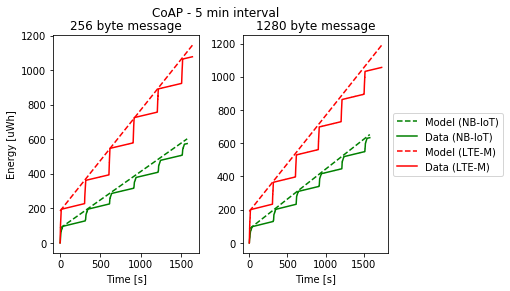

In [12]:
### Plotting the CoAP model test results ### 

fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.3)

fig.suptitle("CoAP - 5 min interval")

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 byte message")
ax2.set_title("1280 byte message")

style = [["g--" , "g"],["r--","r"]]
labels = [["Model (NB-IoT)", "Data (NB-IoT)"], ["Model (LTE-M)", "Data (LTE-M)"]]


for i in range(2):
    curr_durr = coap_test_array[i].duration
    ax1.plot(curr_durr, coap_predictions[i][0]*curr_durr + coap_predictions[i][1], style[i][0])
    ax1.plot(curr_durr, coap_test_array[i].data, style[i][1])

for i in range(2,4):
    curr_durr = coap_test_array[i].duration
    ax2.plot(curr_durr, coap_predictions[i][0]*curr_durr + coap_predictions[i][1], style[i-2][0], label = labels[i-2][0])
    ax2.plot(curr_durr, coap_test_array[i].data, style[i-2][1], label = labels[i-2][1])

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("../dt_thesis/plots/model_test_coap.pdf", bbox_inches='tight')


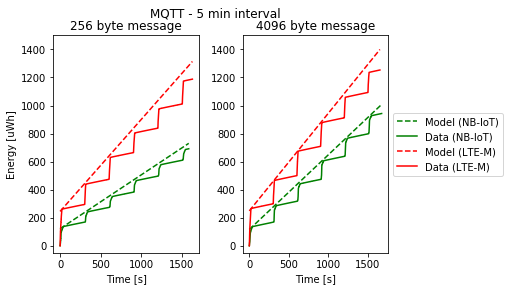

In [13]:
### Plotting the MQTT model test results ### 

fig, (ax1, ax2) = plt.subplots(1,2)

plt.subplots_adjust(wspace = 0.3)

fig.suptitle("MQTT - 5 min interval")

y_min = -50
y_max = 1500

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 byte message")
ax2.set_title("4096 byte message")

style = [["g--" , "g"],["r--","r"]]
labels = [["Model (NB-IoT)", "Data (NB-IoT)"], ["Model (LTE-M)", "Data (LTE-M)"]]

for i in range(2):
    curr_dur = mqtt_test_array[i].duration
    ax1.plot(curr_dur, mqtt_predictions[i][0]*curr_dur + mqtt_predictions[i][1], style[i][0])
    ax1.plot(curr_dur, mqtt_test_array[i].data, style[i][1])

for i in range(2,4):
    curr_dur = mqtt_test_array[i].duration
    ax2.plot(curr_dur, mqtt_predictions[i][0]*curr_dur + mqtt_predictions[i][1], style[i-2][0], label = labels[i-2][0])
    ax2.plot(curr_dur, mqtt_test_array[i].data, style[i-2][1], label = labels[i-2][1])

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("../dt_thesis/plots/model_test_mqtt.pdf", bbox_inches='tight')



In [14]:
### Function for finding the point of transmission in the measured data ###

def get_msg_idxs(test_data):
    
    test_msg_idxs = []

    diff_array = np.diff(test_data, axis=0)
    i = len(diff_array)-1

    while(i > 0):
        curr_diff = diff_array[i]
        if (curr_diff > 0.010):
            test_msg_idxs.append(i)
            i-=960000
        else:
            i-=1
    test_msg_idxs.reverse()
    return test_msg_idxs

In [15]:
### Getting the model error in terms of difference from the measured CoAP transmissions ###


idx = 0
test_tuples_coap = []

for i in coap_test_array:
    test_msg_idxs = get_msg_idxs(i.data)
    
    msg_energy_tuples = []

    for x in test_msg_idxs:
        #new_tuple = ()
        msg_energy_tuples.append(
            100*(1-float(i.data[x])/float(coap_predictions[idx][0]*x*0.00025 + coap_predictions[idx][1])))
    idx += 1
    test_tuples_coap.append(msg_energy_tuples)



In [16]:
### Getting the model error in terms of difference from the measured MQTT transmissions ###

idx = 0
test_tuples_mqtt = []

for i in mqtt_test_array:
    test_msg_idxs = get_msg_idxs(i.data)
    
    msg_energy_tuples = []

    for x in test_msg_idxs:
        #new_tuple = ()
        msg_energy_tuples.append(
            100*(1-float(i.data[x])/float(mqtt_predictions[idx][0]*x*0.00025 + mqtt_predictions[idx][1])))
    idx += 1
    test_tuples_mqtt.append(msg_energy_tuples)

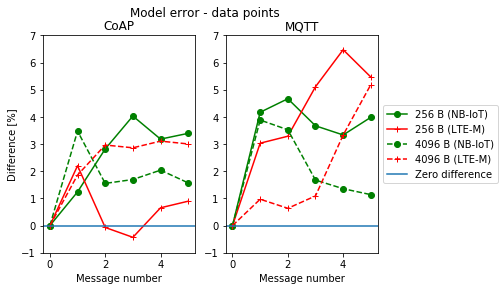

In [17]:
### Plotting the model error in terms of difference from measured data ###

fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle("Model error - data points")

ax1.set_title("CoAP")
ax2.set_title("MQTT")

ax1.set_ylabel("Difference [%]")
ax1.set_xlabel("Message number")
ax2.set_xlabel("Message number")

y_min = -1
y_max = 7

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

labels = ["256 B (NB-IoT)", "256 B (LTE-M)", "4096 B (NB-IoT)", "4096 B (LTE-M)",]
styles = ["g","r","g--","r--"]
markers = ["o","+","o","+"]

for i in range(len(test_tuples_coap)):
    ax1.plot(test_tuples_coap[i], styles[i], marker = markers[i])
    ax2.plot(test_tuples_mqtt[i], styles[i], marker = markers[i],label = labels[i])

ax1.axhline()
ax2.axhline(label = "Zero difference")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("../dt_thesis/plots/model_error_diff.pdf", bbox_inches='tight')

In [18]:
### Getting the model error in terms of slope difference between model and mesured data for CoAP ### 

idx = 0
test_tuples_coap = []

for i in coap_test_array:
    test_msg_idxs = get_msg_idxs(i.data)
    msg_energy_tuples = []

    acc = []

    real_prev_energy = i.data[test_msg_idxs[0]]
    pred_prev_energy = float(coap_predictions[idx][0]*test_msg_idxs[0]*delta_t + coap_predictions[idx][1]) 

    for x in range(1,len(test_msg_idxs)):
        curr_msg_idx = test_msg_idxs[x]

        real_curr_energy = i.data[curr_msg_idx]
        real_energy_diff = real_curr_energy-real_prev_energy
        real_prev_energy = real_curr_energy
        
        pred_curr_energy = float(coap_predictions[idx][0]*curr_msg_idx*delta_t + coap_predictions[idx][1]) 
        pred_energy_diff = pred_curr_energy - pred_prev_energy
        pred_prev_energy = pred_curr_energy

        acc.append(100*(1-real_energy_diff/pred_energy_diff))

        msg_energy_tuples.append(
            100*(1-real_energy_diff/pred_energy_diff))
    idx += 1
    test_tuples_coap.append(msg_energy_tuples)
    print("AVG %d: %f (+/- %f)" %(idx, np.mean(acc), np.std(acc)))


AVG 1: 4.069671 (+/- 2.735516)
AVG 2: 1.099228 (+/- 3.788903)
AVG 3: 1.826719 (+/- 3.076915)
AVG 4: 3.690887 (+/- 1.073311)


In [19]:
### Getting the model error in terms of slope difference between model and mesured data for CoAP ### 

idx = 0
test_tuples_mqtt = []

for i in mqtt_test_array:
    test_msg_idxs = get_msg_idxs(i.data)
    msg_energy_tuples = []

    acc = []

    real_prev_energy = i.data[test_msg_idxs[0]]
    pred_prev_energy = float(mqtt_predictions[idx][0]*test_msg_idxs[0]*delta_t + mqtt_predictions[idx][1]) 

    for x in range(1,len(test_msg_idxs)):
        curr_msg_idx = test_msg_idxs[x]

        real_curr_energy = i.data[curr_msg_idx]
        real_energy_diff = real_curr_energy-real_prev_energy
        real_prev_energy = real_curr_energy
        
        pred_curr_energy = float(mqtt_predictions[idx][0]*curr_msg_idx*delta_t + mqtt_predictions[idx][1]) 
        pred_energy_diff = pred_curr_energy - pred_prev_energy
        pred_prev_energy = pred_curr_energy

        acc.append(100*(1-real_energy_diff/pred_energy_diff))        

        msg_energy_tuples.append(
            100*(1-real_energy_diff/pred_energy_diff))
    idx += 1
    test_tuples_mqtt.append(msg_energy_tuples)
    print("AVG %d: %f (+/- %f)" %(idx, np.mean(acc), np.std(acc)))


AVG 1: 4.914882 (+/- 3.252804)
AVG 2: 6.924093 (+/- 4.517894)
AVG 3: 1.313235 (+/- 3.589956)
AVG 4: 6.500503 (+/- 6.159861)


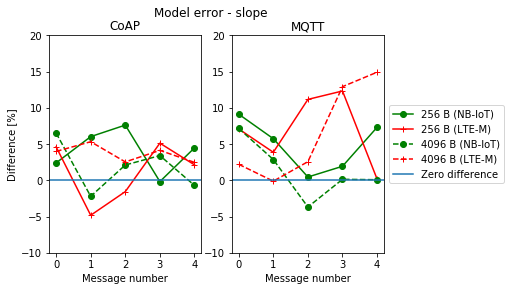

In [20]:
### Plotting the slope error ###

fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle("Model error - slope")

ax1.set_title("CoAP")
ax2.set_title("MQTT")

ax1.set_ylabel("Difference [%]")
ax1.set_xlabel("Message number")
ax2.set_xlabel("Message number")

y_min = -10
y_max = 20

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

labels = ["256 B (NB-IoT)", "256 B (LTE-M)", "4096 B (NB-IoT)", "4096 B (LTE-M)",]
styles = ["g","r","g--","r--"]
markers = ["o","+","o","+"]

for i in range(len(test_tuples_coap)):
    ax1.plot(test_tuples_coap[i], styles[i], marker = markers[i])
    ax2.plot(test_tuples_mqtt[i], styles[i], marker = markers[i],label = labels[i])

ax1.axhline()
ax2.axhline(label = "Zero difference")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("../dt_thesis/plots/model_error_slope.pdf", bbox_inches='tight')

[1.7544142772356361, 1.9186060792367157, 1.9803860867078282, 2.042030782676042, 2.0441517683618122, 2.046011248412408]
[3.3561493068227315, 3.6553585361167253, 3.7673137336258344, 3.8786841855541407, 3.88251004957671, 3.885863877276516]
[6.174923473204056, 6.677771790909904, 6.864095222363884, 7.048470229548443, 7.054786800682079, 7.060323094751732]
[10.64535152556665, 11.384292888319424, 11.653943638164913, 11.918606080668923, 11.927635347810023, 11.935547186484127]
[31.64817717165829, 32.16542746305617, 32.341622059829426, 32.50856665240073, 32.51416115987316, 32.519057933706186]
[1.4538392250271241, 1.5986881124326975, 1.6536054489302303, 1.7086311176665996, 1.7105284459966168, 1.7121920682247422]
[2.8020444943156826, 3.070105540136648, 3.1712321584334826, 3.27228165253238, 3.2757609940918964, 3.278811493108924]
[5.224487836563007, 5.687439975875219, 5.860544778783485, 6.032681681109814, 6.038593900844351, 6.043776607321693]
[9.202313761655565, 9.912946892378955, 10.174858993332979,

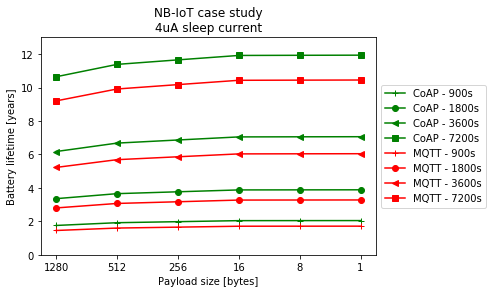

In [21]:
### Calculation and plotting of battery life in years for a NB-IoT application 5wh battery with 4uA sleep current ###

psm_length_test_array = [900,1800,3600,7200,86400]
msg_size_test_array = [1,8,16,256,512,1280]
msg_size_test_array.reverse()

sleep_power = 4*V #uW
capacity = 5000000 #wh

coap_test_times = []
mqtt_test_times = []

#CoAP
for i in psm_length_test_array:
    test_time_coap = []
    test_time_mqtt = []
    for j in msg_size_test_array:
        curr_mqtt_test   = Test(mqtt_256_nb, i,j, timing_mqtt_nb, energy_mqtt_nb, get_data_start(mqtt_256_nb), E_cdrx_nb)
        curr_coap_test   = Test(coap_256_nb, i,j, timing_coap_nb, energy_coap_nb, get_data_start(coap_256_nb), E_cdrx_nb)

        curr_mqtt_energy = get_energy(
            n_bytes      = curr_mqtt_test.n_bytes, 
            max_bytes    = 1439, 
            T_msg        = curr_mqtt_test.T_msg,
            E_cdrx       = curr_mqtt_test.cdrx,
            p_sleep      = sleep_power,
            reg_coeffs_t = curr_mqtt_test.t,
            reg_coeffs_e = curr_mqtt_test.E,
            start_params = curr_mqtt_test.E_start
        )

        curr_coap_energy = get_energy(
            n_bytes      = curr_coap_test.n_bytes, 
            max_bytes    = 1439, 
            T_msg        = curr_coap_test.T_msg,
            E_cdrx       = curr_coap_test.cdrx,
            p_sleep      = sleep_power,
            reg_coeffs_t = curr_coap_test.t,
            reg_coeffs_e = curr_coap_test.E,
            start_params = curr_coap_test.E_start
        )

        test_time_mqtt.append(((capacity - curr_mqtt_energy[1])/curr_mqtt_energy[0])/3600/24/365)
        test_time_coap.append(((capacity - curr_coap_energy[1])/curr_coap_energy[0])/3600/24/365)

    mqtt_test_times.append(test_time_mqtt)
    coap_test_times.append(test_time_coap)

plt.title("NB-IoT case study\n4uA sleep current")
plt.ylabel("Battery lifetime [years]")
plt.xlabel("Payload size [bytes]")
plt.ylim([0,13])

labels = ["CoAP - 900s", "CoAP - 1800s", "CoAP - 3600s", "CoAP - 7200s", None]
markers = ["+","o","<", "s", None]
idx = 0
for i in coap_test_times:
    plt.plot(i, color="g", marker=markers[idx], label = labels[idx])
    print(i)
    idx += 1

labels = ["MQTT - 900s", "MQTT - 1800s", "MQTT - 3600s", "MQTT - 7200s", None]
idx = 0
for i in mqtt_test_times:
    plt.plot(i, color="r", marker=markers[idx], label = labels[idx])
    print(i)
    idx += 1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(range(len(msg_size_test_array)), msg_size_test_array)

for i in range(len(psm_length_test_array)):
    print(100*(coap_test_times[i][5]/coap_test_times[i][0]-1))
for i in range(len(psm_length_test_array)):
    print(100*(mqtt_test_times[i][5]/mqtt_test_times[i][0]-1))


plt.savefig("../dt_thesis/plots/case_study_nb.pdf", bbox_inches='tight')

[0.9855516008428679, 0.9715056219497485, 0.9669121780650479, 0.9626451001182527, 0.962503512716039, 0.9623796579005811]
[1.9219846372437404, 1.8952657992010398, 1.8865238415769192, 1.878401182979861, 1.8781316321496453, 1.8778958386255833]
[3.6614868912725598, 3.61297038497677, 3.5970826787689814, 3.5823143359340506, 3.581824146043537, 3.5813953399221963]
[11.399099281924608, 11.281193983698852, 11.242432373147983, 11.206334500817356, 11.205135230269518, 11.204086079082497]
[27.601531516515912, 27.4856017614728, 27.447174615650432, 27.411246623914412, 27.410050644016298, 27.409004247212952]
[0.8429777993693379, 0.8549093604771594, 0.8589619611837349, 0.8627963249281102, 0.8629247267063502, 0.8630371096168186]
[1.6498897097284264, 1.6727358942289086, 1.6804925425932478, 1.687830018905656, 1.6880757051198148, 1.6882907392382271]
[3.164395891801636, 3.2063919939929266, 3.2206395060962003, 3.234112023560531, 3.234563048966324, 3.234957799403443]
[10.157209546594464, 10.265099062360246, 10.

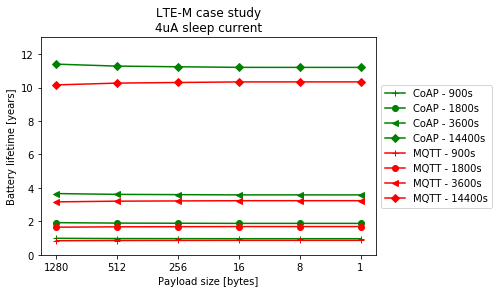

In [22]:
### Calculation and plotting of battery life in years for a LTE-M application 5wh battery with 4uA sleep current ###

psm_length_test_array = [900,1800,3600,14400,86400]
msg_size_test_array = [1,8,16,256,512,1280]
msg_size_test_array.reverse()

sleep_power = 4*V
capacity = 5000000 #ah

coap_test_times = []
mqtt_test_times = []


#CoAP
for i in psm_length_test_array:
    test_time_coap = []
    test_time_mqtt = []
    for j in msg_size_test_array:
        curr_mqtt_test   = Test(mqtt_256_ltem, i,j, timing_mqtt_ltem, energy_mqtt_ltem, get_data_start(mqtt_256_ltem), E_cdrx_ltem)
        curr_coap_test   = Test(coap_256_ltem, i,j, timing_coap_ltem, energy_coap_ltem, get_data_start(coap_256_ltem), E_cdrx_ltem)

        curr_mqtt_energy = get_energy(
            n_bytes      = curr_mqtt_test.n_bytes, 
            max_bytes    = 1439, 
            T_msg        = curr_mqtt_test.T_msg,
            E_cdrx       = curr_mqtt_test.cdrx,
            p_sleep      = sleep_power,
            reg_coeffs_t = curr_mqtt_test.t,
            reg_coeffs_e = curr_mqtt_test.E,
            start_params = curr_mqtt_test.E_start
        )

        curr_coap_energy = get_energy(
            n_bytes      = curr_coap_test.n_bytes, 
            max_bytes    = 1439, 
            T_msg        = curr_coap_test.T_msg,
            E_cdrx       = curr_coap_test.cdrx,
            p_sleep      = sleep_power,
            reg_coeffs_t = curr_coap_test.t,
            reg_coeffs_e = curr_coap_test.E,
            start_params = curr_coap_test.E_start
        )

        test_time_mqtt.append(((capacity - curr_mqtt_energy[1])/curr_mqtt_energy[0])/3600/24/365)
        test_time_coap.append(((capacity - curr_coap_energy[1])/curr_coap_energy[0])/3600/24/365)

    mqtt_test_times.append(test_time_mqtt)
    coap_test_times.append(test_time_coap)

plt.title("LTE-M case study\n4uA sleep current")
plt.ylabel("Battery lifetime [years]")
plt.xlabel("Payload size [bytes]")
plt.ylim([0,13])

labels = ["CoAP - 900s", "CoAP - 1800s", "CoAP - 3600s",  "CoAP - 14400s", None]
markers = ["+","o","<", "D", None]
idx = 0
for i in coap_test_times:
    print(i)
    plt.plot(i, color="g", marker=markers[idx], label = labels[idx])
    idx += 1

labels = ["MQTT - 900s", "MQTT - 1800s", "MQTT - 3600s", "MQTT - 14400s", None]

idx = 0
for i in mqtt_test_times:
    print(i)
    plt.plot(i, color="r", marker=markers[idx], label = labels[idx])
    idx += 1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(range(len(msg_size_test_array)), msg_size_test_array)

for i in range(len(psm_length_test_array)):
    print(100*(coap_test_times[i][5]/coap_test_times[i][0]-1))
for i in range(len(psm_length_test_array)):
    print(100*(mqtt_test_times[i][5]/mqtt_test_times[i][0]-1))

plt.savefig("../dt_thesis/plots/case_study_ltem.pdf", bbox_inches='tight')